In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import CactusDataset
from sklearn.metrics import roc_curve, auc


In [14]:
#use_gpu = torch.cuda.is_available()
#if use_gpu:
#    print("Using CUDA")

In [39]:
data_dir = '../../../data/train/train'
csv_file = '../../../data/train.csv'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

#set the transforms for the images
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])


torch.manual_seed(42)
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir, data_transforms)
# split into train, eval, test
train_size = int(0.7 * len(image_dataset))
eval_size = int(0.2 * len(image_dataset))
test_size = len(image_dataset) - train_size - eval_size
train_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, eval_size, test_size])

image_datasets = {TRAIN: train_dataset, VAL: eval_dataset, TEST: test_dataset}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

batch_sizes = {TRAIN: dataset_sizes[TRAIN], VAL: dataset_sizes[VAL], TEST: 64}

dataloaders = {TRAIN: None, VAL: None, TEST: None}
dataloaders[TRAIN] = DataLoader(image_datasets[TRAIN], batch_size=batch_sizes[TRAIN],
                                             shuffle=True, num_workers=0)
dataloaders[VAL] = DataLoader(image_datasets[VAL], batch_size=batch_sizes[VAL],
                                             shuffle=False, num_workers=0)
dataloaders[TEST] = DataLoader(image_datasets[TEST], batch_size=batch_sizes[TEST], shuffle=False, num_workers=0)


print(dataset_sizes)
class_names = {0: 'No Cactus', 1: 'Cactus'}

inputs, classes = next(iter(dataloaders[TRAIN]))
print(inputs[0])

n_features = 32 * 32 * 3

print(n_features)

#print nunmber of each class in each dataset
for x in [TRAIN, VAL, TEST]:
    print("Number of {} images: {}".format(x, dataset_sizes[x]))
    for i in range(2):
        print("Number of {} images of class {}: {}".format(x, class_names[i], sum([1 for j in image_datasets[x] if j[1] == i])))
    print()




{'train': 12250, 'val': 3500, 'test': 1750}
tensor([[[0.3333, 0.4549, 0.4353,  ..., 0.3098, 0.2980, 0.2353],
         [0.5333, 0.5490, 0.1020,  ..., 0.3882, 0.4118, 0.4078],
         [0.5294, 0.5059, 0.3804,  ..., 0.1294, 0.6784, 0.3098],
         ...,
         [0.5804, 0.4118, 0.4471,  ..., 0.4706, 0.4941, 0.5216],
         [0.4392, 0.4549, 0.3216,  ..., 0.5373, 0.3490, 0.2275],
         [0.3412, 0.5294, 0.3608,  ..., 0.2784, 0.4510, 0.2863]],

        [[0.3176, 0.4392, 0.4196,  ..., 0.2627, 0.2549, 0.1922],
         [0.5176, 0.5333, 0.0863,  ..., 0.3412, 0.3686, 0.3647],
         [0.5137, 0.4902, 0.3647,  ..., 0.0902, 0.6392, 0.2784],
         ...,
         [0.5922, 0.4235, 0.4588,  ..., 0.4863, 0.5216, 0.5569],
         [0.4510, 0.4667, 0.3333,  ..., 0.5647, 0.3843, 0.2706],
         [0.3529, 0.5412, 0.3725,  ..., 0.3059, 0.4863, 0.3294]],

        [[0.2745, 0.3961, 0.3765,  ..., 0.3176, 0.3098, 0.2549],
         [0.4745, 0.4902, 0.0431,  ..., 0.3882, 0.4235, 0.4196],
         [0.46

In [40]:
# Create model
# f = wx + b, sigmoid at the end
class LogisticRegression(nn.Module):

    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted

In [56]:
def train_model(model, criterion, optimizer, model_name, X_train, y_train, X_val, y_val, transforms=None, num_epochs=1000):
    # training loop
    num_epochs = num_epochs
    epoch_best = 0
    f1_scores = []
    accs_train = []
    accs_val = []
    aucs = []
    best_fpr = []
    best_tpr = []
    best_auc = 0
    best_acc = 0
    best_f1 = 0
    

    #40k epoche runnate
    for epoch in range(num_epochs):
        #randomly horizontal flip the images in X_train
        if transforms is not None:
            X_train = transforms(X_train)
        #use mini batches
        # forward pass and loss
        outputs = model(X_train)
        #make y_predicted and y_train of same shape
        outputs = outputs.view(-1)

        preds = outputs.round()
        acc_train = (preds == y_train).sum() / y_train.shape[0]
        accs_train.append(acc_train)

        loss = criterion(outputs, y_train.float())
        
        # backward pass
        loss.backward()
        
        # updates
        optimizer.step()
        
        # zero gradients
        optimizer.zero_grad()
        
        with torch.no_grad():
            outputs = model(X_val)  # no need to call model.forward()
            y_predicted_cls = outputs.round()   # round off to nearest class
            #flatten
            y_val = y_val.view(-1)
            y_predicted_cls = y_predicted_cls.view(-1)

            #Compute f1 score
            tp = (y_val * y_predicted_cls).sum()
            tn = ((1 - y_val) * (1 - y_predicted_cls)).sum()
            fp = ((1 - y_val) * y_predicted_cls).sum()
            fn = (y_val * (1 - y_predicted_cls)).sum()
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * precision * recall / (precision + recall)
            f1_scores.append(f1)

            #Compute accuracy
            acc = (y_predicted_cls == y_val).sum() / y_val.shape[0]   # accuracy
            accs_val.append(acc)

            #Compute AUC
            fpr, tpr, _ = roc_curve(y_val, outputs)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            
            if roc_auc > best_auc:
                best_auc = roc_auc
                best_fpr = fpr
                best_tpr = tpr
                epoch_best = epoch
            if f1 > best_f1:
                best_f1 = f1
            if acc > best_acc:
                best_acc = acc

            if epoch % 100 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item()}, Accuracy on val: {acc}, F1 score on val: {f1}, AUC on val: {roc_auc}')
    return accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best

## LR without PCA

In [42]:
#Load dataset, we flatten the images and we put them in a single numpy array in memory of shape (n_images, n_features)
X_train = []
y_train = []
for images, labels in dataloaders[TRAIN]:
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
for images, labels in dataloaders[VAL]:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_train[0])
n_features = X_train.shape[1]

torch.Size([12250, 3072])
torch.Size([12250])
torch.Size([3500, 3072])
torch.Size([3500])
tensor([0.5098, 0.4549, 0.4078,  ..., 0.4118, 0.5255, 0.4745])


In [46]:
#instantiate model
model = LogisticRegression(n_features)
# Loss and optimizer
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch: 0, Loss: 0.6215795874595642, Accuracy on val: 0.7554285526275635, F1 score on val: 0.8606770634651184, AUC on val: 0.37635821539157605
Epoch: 100, Loss: 0.5365254878997803, Accuracy on val: 0.7554285526275635, F1 score on val: 0.8606770634651184, AUC on val: 0.6739872149249932
Epoch: 200, Loss: 0.5009434223175049, Accuracy on val: 0.7645714282989502, F1 score on val: 0.8648737668991089, AUC on val: 0.7777004803681762
Epoch: 300, Loss: 0.4752424359321594, Accuracy on val: 0.7725714445114136, F1 score on val: 0.8664429783821106, AUC on val: 0.814482093118611
Epoch: 400, Loss: 0.4561351239681244, Accuracy on val: 0.774571418762207, F1 score on val: 0.8655189275741577, AUC on val: 0.8322020762933533
Epoch: 500, Loss: 0.44149649143218994, Accuracy on val: 0.7765714526176453, F1 score on val: 0.8648928999900818, AUC on val: 0.8427841383064459
Epoch: 600, Loss: 0.4299573004245758, Accuracy on val: 0.7820000052452087, F1 score on val: 0.8667249083518982, AUC on val: 0.8500873075346048
E

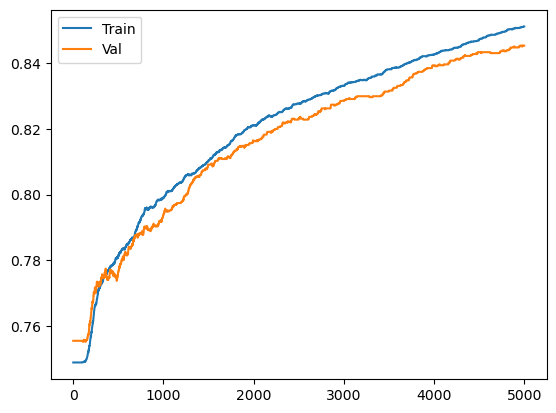

In [47]:
# train model for 5000 epochs
accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best = train_model(model, criterion, optimizer, 'LR', X_train, y_train, X_val, y_val, num_epochs=5000)
print(f'Best AUC: {best_auc}, Best F1: {best_f1}, Best epoch: {epoch_best}')
#plot accuracies of val and training
plt.plot(accs_train, label='Train')
plt.plot(accs_val, label='Val')
plt.legend()
plt.show()

## LR with PCA

In [48]:
from sklearn.decomposition import PCA

In [68]:
#Load dataset, we flatten the images and we put them in a single numpy array in memory of shape (n_images, n_features)
X_train = []
y_train = []
for images, labels in dataloaders[TRAIN]:
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
for images, labels in dataloaders[VAL]:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)

In [69]:
# retain only n_componenets feature with highest variance using PCA
n_components = 612
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train.detach().numpy())
X_val_pca = pca.transform(X_val.detach().numpy())
#transform in tensors
X_train_pca = torch.tensor(X_train_pca)
X_val_pca = torch.tensor(X_val_pca)


In [70]:
model = LogisticRegression(X_train_pca.shape[1])
# Loss and optimizer
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch: 0, Loss: 0.6955661773681641, Accuracy on val: 0.49657142162323, F1 score on val: 0.5911833047866821, AUC on val: 0.5277632216126797
Epoch: 100, Loss: 0.588712215423584, Accuracy on val: 0.8205714225769043, F1 score on val: 0.8776782155036926, AUC on val: 0.86705108197718
Epoch: 200, Loss: 0.5190900564193726, Accuracy on val: 0.8668571710586548, F1 score on val: 0.9126686453819275, AUC on val: 0.9130910048496332
Epoch: 300, Loss: 0.47199633717536926, Accuracy on val: 0.87628573179245, F1 score on val: 0.9196213483810425, AUC on val: 0.9257229823829655
Epoch: 400, Loss: 0.4385039806365967, Accuracy on val: 0.8785714507102966, F1 score on val: 0.9213109612464905, AUC on val: 0.9307343288277461
Epoch: 500, Loss: 0.4136194586753845, Accuracy on val: 0.8811428546905518, F1 score on val: 0.9229344129562378, AUC on val: 0.9332972202977645
Epoch: 600, Loss: 0.39445069432258606, Accuracy on val: 0.8825713992118835, F1 score on val: 0.9238183498382568, AUC on val: 0.9349200976996055
Epoch:

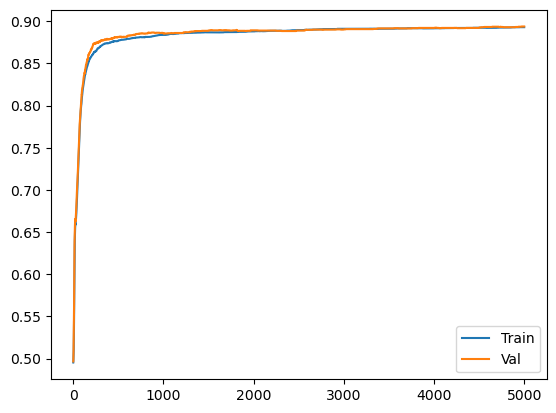

In [71]:
#Train model using pca features
accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best = train_model(model, criterion, optimizer, 'LR', X_train_pca, y_train, X_val_pca, y_val, num_epochs=5000)
print(f'Best AUC: {best_auc}, Best F1: {best_f1}, Best epoch: {epoch_best}')
#plot accuracies of val and training
plt.plot(accs_train, label='Train')
plt.plot(accs_val, label='Val')
plt.legend()
plt.show()


## LR with data standardization and PCA

In [72]:
from sklearn.decomposition import PCA

In [73]:
X_train = []
y_train = []
for images, labels in dataloaders[TRAIN]:
    
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
for images, labels in dataloaders[VAL]:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)

In [74]:
# retain only n_componenets feature with highest variance using PCA
n_components = 612
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train.detach().numpy())
X_val_pca = pca.transform(X_val.detach().numpy())
#transform in tensors
print(X_train_pca.shape)
X_train_pca = torch.tensor(X_train_pca)
X_val_pca = torch.tensor(X_val_pca)

#compute mean of X_train_pca
mean = X_train_pca.mean().item()
std = X_train_pca.std().item()

print(mean)
print(std)

#standardize X_train_pca and X_val_pca using mean and std
X_train_pca = (X_train_pca - mean) / std
X_val_pca = (X_val_pca - mean) / std


(12250, 612)
2.3350201772132095e-08
0.3217628002166748


In [75]:

model = LogisticRegression(X_train_pca.shape[1])
# Loss and optimizer
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch: 0, Loss: 0.6855040788650513, Accuracy on val: 0.5868571400642395, F1 score on val: 0.6619915962219238, AUC on val: 0.6688972210047083
Epoch: 100, Loss: 0.4721888601779938, Accuracy on val: 0.8048571348190308, F1 score on val: 0.8547117114067078, AUC on val: 0.9318837749374353
Epoch: 200, Loss: 0.41601264476776123, Accuracy on val: 0.8382856845855713, F1 score on val: 0.8828157186508179, AUC on val: 0.9385034180723063
Epoch: 300, Loss: 0.38225898146629333, Accuracy on val: 0.8574285507202148, F1 score on val: 0.8984740376472473, AUC on val: 0.9408703536131888
Epoch: 400, Loss: 0.3580951988697052, Accuracy on val: 0.8711428642272949, F1 score on val: 0.9095285534858704, AUC on val: 0.9422449170755157
Epoch: 500, Loss: 0.3398453891277313, Accuracy on val: 0.8794285655021667, F1 score on val: 0.9160031676292419, AUC on val: 0.9431493630438162
Epoch: 600, Loss: 0.3256436586380005, Accuracy on val: 0.8857142925262451, F1 score on val: 0.9209798574447632, AUC on val: 0.9437617529373508

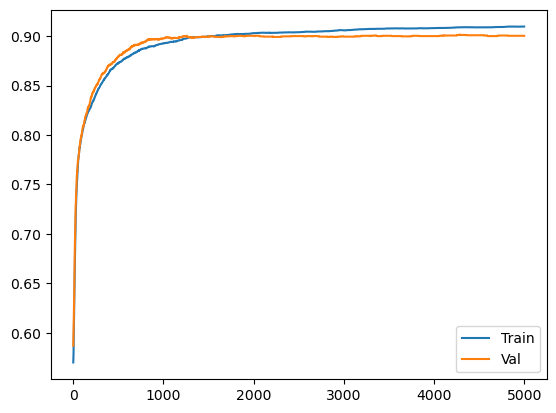

In [76]:

#Train model using pca features
accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best = train_model(model, criterion, optimizer, 'LR', X_train_pca, y_train, X_val_pca, y_val, num_epochs=5000)
print(f'Best AUC: {best_auc}, Best F1: {best_f1}, Best epoch: {epoch_best}')
#plot accuracies of val and training
plt.plot(accs_train, label='Train')
plt.plot(accs_val, label='Val')
plt.legend()
plt.show()


In [103]:
# show memory occupation of the model
# save model on memory
torch.save(model, '../../../data/LRmodel.pth')

In [119]:
from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        model(X_val_pca)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
       model_inference        16.30%     231.000us       100.00%       1.417ms       1.417ms           0 b     -34.16 Kb             1  
          aten::linear         1.13%      16.000us        80.24%       1.137ms       1.137ms      17.08 Kb           0 b             1  
           aten::addmm        72.90%       1.033ms        75.37%       1.068ms       1.068ms      17.08 Kb      17.08 Kb             1  
               aten::t         2.26%      32.000us         3.74%      53.000us      53.000us           0 b           0 b             1  
         aten::sigmoid         3.46%     

STAGE:2024-05-01 18:26:34 131981:131981 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-01 18:26:34 131981:131981 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-01 18:26:34 131981:131981 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


## LR with PCA, normalization and histogram equalization

In [77]:
from sklearn.decomposition import PCA

In [78]:
data_dir = '../../../data/train/train'
csv_file = '../../../data/train.csv'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

#set the transforms for the images
data_transforms = transforms.Compose([
    transforms.RandomEqualize(p=1),
    transforms.ToTensor(),
])


torch.manual_seed(42)
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir, data_transforms)
# split into train, eval, test
train_size = int(0.7 * len(image_dataset))
eval_size = int(0.2 * len(image_dataset))
test_size = len(image_dataset) - train_size - eval_size
train_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, eval_size, test_size])


In [79]:
X_train = []
y_train = []
dataloader = DataLoader(train_dataset, batch_size=train_size, shuffle=True, num_workers=0)
for images, labels in dataloader:
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
dataloader = DataLoader(eval_dataset, batch_size=eval_size, shuffle=False, num_workers=0)
for images, labels in dataloader:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)

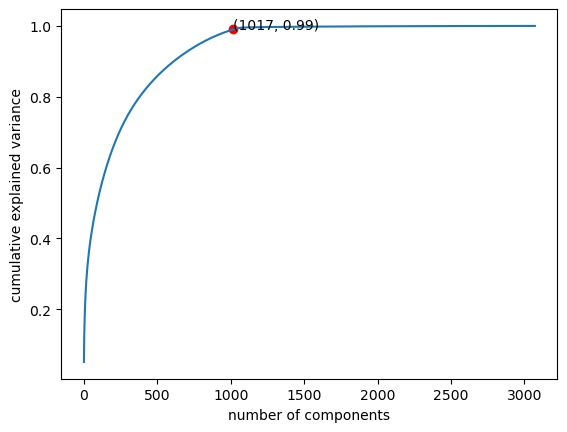

Number of components for 95% variance:  1017
(12250, 1017)
-1.664250071087281e-08
0.5086983442306519


In [80]:
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)
#plot number of features vs explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.99)
plt.scatter(n_components, 0.99, color='r')
plt.text(n_components, 0.99, '({}, {})'.format(n_components, 0.99), color='black')

plt.show()

#print n_components for 95% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.99)
print('Number of components for 95% variance: ', n_components)

# retain only n_componenets feature with highest variance using PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train.detach().numpy())
X_val_pca = pca.transform(X_val.detach().numpy())
#transform in tensors
print(X_train_pca.shape)
X_train_pca = torch.tensor(X_train_pca)
X_val_pca = torch.tensor(X_val_pca)

#compute mean of X_train_pca
mean = X_train_pca.mean().item()
std = X_train_pca.std().item()

print(mean)
print(std)

#standardize X_train_pca and X_val_pca using mean and std
X_train_pca = (X_train_pca - mean) / std
X_val_pca = (X_val_pca - mean) / std


In [81]:
model = LogisticRegression(X_train_pca.shape[1])
# Loss and optimizer
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch: 0, Loss: 0.7499816417694092, Accuracy on val: 0.4837142825126648, F1 score on val: 0.5856454968452454, AUC on val: 0.47189346890155104
Epoch: 100, Loss: 0.5748289227485657, Accuracy on val: 0.7002857327461243, F1 score on val: 0.777045726776123, AUC on val: 0.7806742828057177
Epoch: 200, Loss: 0.519709050655365, Accuracy on val: 0.7480000257492065, F1 score on val: 0.8218181729316711, AUC on val: 0.8056479491566163
Epoch: 300, Loss: 0.48377543687820435, Accuracy on val: 0.7722856998443604, F1 score on val: 0.8443055748939514, AUC on val: 0.8176765945112899
Epoch: 400, Loss: 0.4584314525127411, Accuracy on val: 0.7848571538925171, F1 score on val: 0.8562153577804565, AUC on val: 0.8258431186109972
Epoch: 500, Loss: 0.43975383043289185, Accuracy on val: 0.7925714254379272, F1 score on val: 0.8633282780647278, AUC on val: 0.8318331401020826
Epoch: 600, Loss: 0.4254907965660095, Accuracy on val: 0.7994285821914673, F1 score on val: 0.8691763281822205, AUC on val: 0.8364821779518429


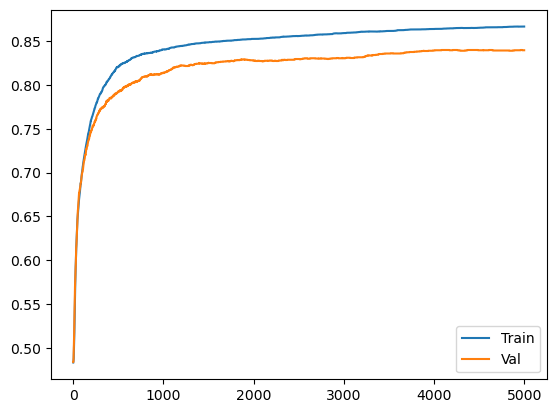

In [82]:
#Train model using pca features
accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best = train_model(model, criterion, optimizer, 'LR', X_train_pca, y_train, X_val_pca, y_val, num_epochs=5000)
print(f'Best AUC: {best_auc}, Best F1: {best_f1}, Best epoch: {epoch_best}')
#plot accuracies of val and training
plt.plot(accs_train, label='Train')
plt.plot(accs_val, label='Val')
plt.legend()
plt.show()


## LR with oversampling

In [83]:
from sklearn.decomposition import PCA

In [84]:
data_dir = '../../../data/train/train'
csv_file = '../../../data/train.csv'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

#set the transforms for the images
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])


torch.manual_seed(42)
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir, data_transforms)
print(image_dataset.get_class_distribution())


image_dataset.oversample()
print(len(image_dataset))

# print number of classes
print(image_dataset.get_class_distribution())

# split into train, eval, test
train_size = int(0.7 * len(image_dataset))
eval_size = int(0.2 * len(image_dataset))
test_size = len(image_dataset) - train_size - eval_size
train_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, eval_size, test_size])

n_features = 32 * 32 * 3

{1: 13136, 0: 4364}
21864
{1: 13136, 0: 8728}


In [85]:
X_train = []
y_train = []
dataloader = DataLoader(train_dataset, batch_size=train_size, shuffle=True, num_workers=0)
for images, labels in dataloader:
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
dataloader = DataLoader(eval_dataset, batch_size=eval_size, shuffle=False, num_workers=0)
for images, labels in dataloader:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)
n_features = X_train.shape[1]

In [86]:
# retain only n_componenets feature with highest variance using PCA
n_components = 612
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train.detach().numpy())
X_val_pca = pca.transform(X_val.detach().numpy())
#transform in tensors
X_train_pca = torch.tensor(X_train_pca)
X_val_pca = torch.tensor(X_val_pca)

#Standardize
mean = X_train_pca.mean().item()
std = X_train_pca.std().item()
X_train_pca = (X_train_pca - mean) / std
X_val_pca = (X_val_pca - mean) / std

In [88]:
#instantiate model
model = LogisticRegression(n_components)
# Loss and optimizer
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch: 0, Loss: 0.6951662302017212, Accuracy on val: 0.5718206763267517, F1 score on val: 0.6236429214477539, AUC on val: 0.6036461023717044
Epoch: 100, Loss: 0.4250999391078949, Accuracy on val: 0.8408051133155823, F1 score on val: 0.8559006452560425, AUC on val: 0.9193651442125517
Epoch: 200, Loss: 0.37346339225769043, Accuracy on val: 0.8481244444847107, F1 score on val: 0.8635429739952087, AUC on val: 0.9284148509616349
Epoch: 300, Loss: 0.3516766428947449, Accuracy on val: 0.8533851504325867, F1 score on val: 0.8692103624343872, AUC on val: 0.9312423943351572
Epoch: 400, Loss: 0.33895882964134216, Accuracy on val: 0.85773104429245, F1 score on val: 0.8739359378814697, AUC on val: 0.9325962788971709
Epoch: 500, Loss: 0.33031460642814636, Accuracy on val: 0.8607044816017151, F1 score on val: 0.8770442605018616, AUC on val: 0.9334179302487036
Epoch: 600, Loss: 0.32391488552093506, Accuracy on val: 0.863449215888977, F1 score on val: 0.8797582983970642, AUC on val: 0.9340237701797833


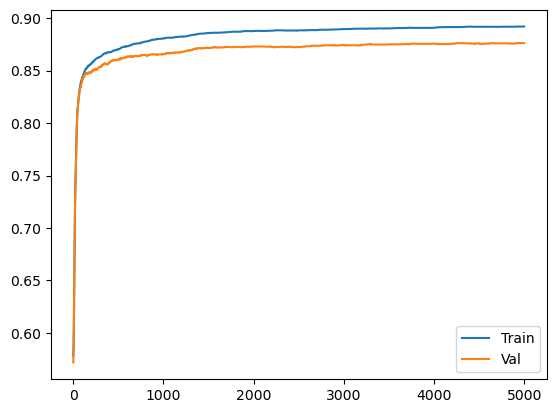

In [89]:
# train model for 5000 epochs
accs_train, accs_val, aucs, f1_scores, best_fpr, best_tpr, best_auc, best_f1, epoch_best = train_model(model, criterion, optimizer, 'LR', X_train_pca, y_train, X_val_pca, y_val, num_epochs=5000)
print(f'Best AUC: {best_auc}, Best F1: {best_f1}, Best epoch: {epoch_best}')
#plot accuracies of val and training
plt.plot(accs_train, label='Train')
plt.plot(accs_val, label='Val')
plt.legend()
plt.show()